# Learning and Decision Making

## Laboratory 5: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The puddle world domain

Consider the puddleworld domain from the homework, depicted in the figure below.

<img src="puddleworld.png" width="400px">

In it, an all terrain vehicle must navigate a 20 &times; 20 gridworld. The three shaded cells in the upper right corner correspond to the goal state, while the L-shaped shaded cells in the middle of the grid correspond to a puddle in which the vehicle may get stuck and damaged. 

The vehicle has available the standard four actions, _up_, _down_, _left_ and _right_. Each action

* Succeeds and moves the vehicle to the adjacent cell in the corresponding direction with a probability of $0.92$; 
* Fails and moves the vehicle to any of the other 3 adjacent cells with a probability of $0.2$; 
* Fails and the vehicle remains in the same cell with a probability of $0.2$.

The vehicle incurs maximal cost ($1$) for standing in the darker part of the puddle; in the lighter part of the puddle, it incurs a cost of $0.5$. Each movement costs $0.05$ and the goal cells cost $0$.

The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

<IPython.core.display.Javascript object>


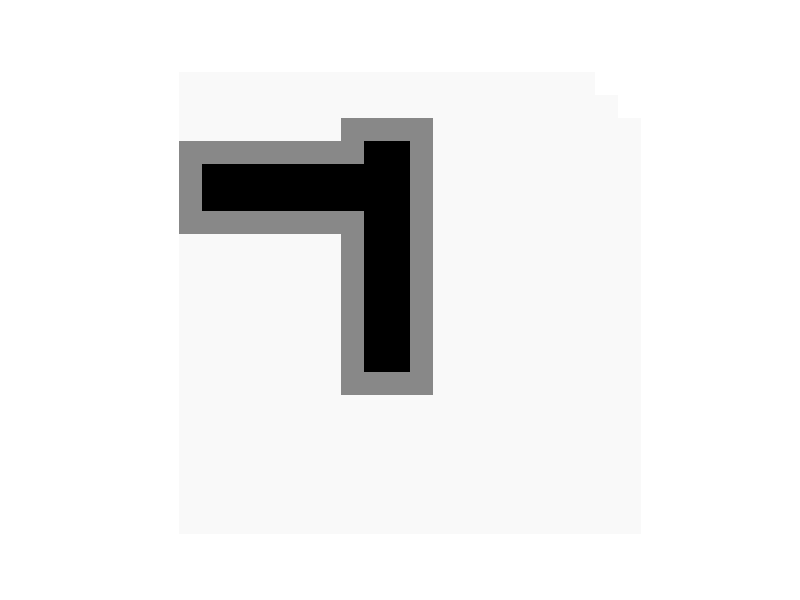

In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Problem specific parameters
GRIDSIZE = 20

def puddlecost(x):
    ''' puddlecost : int -> int

        puddlecost(x) returns the cost for the puddle area corresponding to state x:
        * if x is in the dark puddle area, it returns 1;
        * if x is in the light puddle area, it returns 0.5;
        * otherwise, it returns 0.
        
    '''

    i = x // GRIDSIZE
    j = x % GRIDSIZE
    
    if (j in (4, 5) and i in range(1, 8)) or \
       (i in (8, 9) and j in range(3, 13)):
        return 1.0
    
    if (j in range(3, 7) and i in range(0, 9)) or \
       (i in range(7, 11) and j in range(2, 14)):
        return 0.5
    
    return 0

# -- End: puddlecost


np.set_printoptions(threshold=10)


# States
X = [(i, j) for i in range(GRIDSIZE) for j in range(GRIDSIZE)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities and cost
Pu = np.zeros((nX, nX))
Pd = np.zeros((nX, nX))
Pl = np.zeros((nX, nX))
Pr = np.zeros((nX, nX))

c = np.zeros((nX, nA))

for x in range(nX):
    (i, j) = X[x]
    
    xu = X.index((i, max(j - 1, 0)))
    xd = X.index((i, min(j + 1, GRIDSIZE - 1)))
    xl = X.index((max(i - 1, 0), j))
    xr = X.index((min(i + 1, GRIDSIZE - 1), j))
    
    # Successfull transition
    Pu[x, xu] += 0.92
    Pd[x, xd] += 0.92
    Pl[x, xl] += 0.92
    Pr[x, xr] += 0.92

    # Failed transition (stays in place)
    Pu[x, x] += 0.02
    Pd[x, x] += 0.02
    Pl[x, x] += 0.02
    Pr[x, x] += 0.02

    # Failed transition (oposite direction)
    Pu[x, xd] += 0.02
    Pd[x, xu] += 0.02
    Pl[x, xr] += 0.02
    Pr[x, xl] += 0.02

    # Failed transition (sideways)
    Pu[x, xl] += 0.02
    Pu[x, xr] += 0.02
    Pd[x, xl] += 0.02
    Pd[x, xr] += 0.02
    Pl[x, xu] += 0.02
    Pl[x, xd] += 0.02
    Pr[x, xu] += 0.02
    Pr[x, xd] += 0.02
    
    if x not in (GRIDSIZE * (GRIDSIZE - 2), GRIDSIZE * (GRIDSIZE - 1), GRIDSIZE * (GRIDSIZE - 1) + 1):
        c[x, :] = min(0.05 + puddlecost(x), 1)
    
P = [Pu, Pd, Pl, Pr]

# Discount
gamma = 0.95

# Observe cost function
plt.figure()
plt.imshow(c[:, 0].reshape(GRIDSIZE, GRIDSIZE).T, cmap='Greys', origin='upper')
plt.axis('off')
plt.show()

---

#### Activity 1.        

Compute the optimal $Q$-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [2]:
J = np.zeros((nX,1))

err = 1
i = 0

Q1 = np.zeros((nX,nA))

while err > 1e-8:
    Q1u = np.array([c[:,0]]).T + gamma*Pu.dot(J)
    Q1d = np.array([c[:,0]]).T + gamma*Pd.dot(J)
    Q1l = np.array([c[:,0]]).T + gamma*Pl.dot(J)
    Q1r = np.array([c[:,0]]).T + gamma*Pr.dot(J)
    
    Jnew = np.min((Q1u, Q1d, Q1l, Q1r), axis=0)
    err = np.linalg.norm(Jnew - J)
    J = Jnew
    
Q1[:,0] = Q1u[:,0]
Q1[:,1] = Q1d[:,0]
Q1[:,2] = Q1l[:,0]
Q1[:,3] = Q1u[:,0]
print(Q1)

[[0.66620904 0.68217221 0.66620904 0.66620904]
 [0.66785407 0.70889182 0.68381724 0.66785407]
 [0.69667514 1.20781559 0.72174972 0.69667514]
 ...
 [0.60463208 0.64360831 0.63873085 0.60463208]
 [0.62676186 0.6632013  0.65874274 0.62676186]
 [0.64725131 0.66476978 0.67693514 0.64725131]]


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [3]:
def action_to_number(action):
    aux = {'U':0, 'D':1, 'L':2, 'R':3}
    return aux[action]    

In [4]:
import random
import numpy.random as rnd

def exploration(x, Q=None):
    return action_to_number(random.choice(A))

def exploitation(x, Q):
    return np.random.choice(np.argwhere(Q[x,:] == np.amin(Q[x,:]))[:,0])
        

def Q_greedy(x, Q, e=0.1):
    funct = rnd.choice([exploration, exploitation], p = [e, 1-e])
    return funct(x, Q)


### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for $500,000$ iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the vehicle to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal $Q$-function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

In [15]:
import numpy as np

est_Pu = np.identity(nX)
est_Pd = np.identity(nX)
est_Pl = np.identity(nX)
est_Pr = np.identity(nX)
est_P = [est_Pu, est_Pd, est_Pl, est_Pr]
est_c = np.zeros((nX, nA))
N = np.zeros((nX, nA))


def step_size(x, xa):
    return (1 / (N[x,xa] +1))

def calc_est_P(x, next_x, xa, step_size):
    pxa = est_P[xa][x,:]
    vector = np.zeros(400)
    vector[next_x] = 1
    est_P[xa][x,:] = pxa + step_size*(vector-pxa)

def calc_est_c(x, xa, step_size):
    est_c[x,xa] = est_c[x,xa] + step_size*(c[x,xa]-est_c[x,xa])
    return est_c[x,xa]
    


xs_aux = [i for i in range(nX)]
def act(x, xa):
    next_x = rnd.choice(xs_aux, p = P[xa][x])
    if X[x] in [(18,0), (19,0), (19,1)]:
        return next_x, True
    else:
        return next_x, False
    
Q2_saved = []

x = rnd.choice(nX-1)
index = 0
Q2 = np.zeros((nX,nA))
while index < 500000:
    xa = Q_greedy(x, Q2)
    N[x, xa] += 1
    step_size_var = step_size(x, xa)
    next_x, done = act(x, xa)
    aux_est_c = calc_est_c(x, xa, step_size_var)
    calc_est_P(x, next_x, xa, step_size_var)
    Q2[x, xa] = aux_est_c + gamma*(est_P[xa][x,:].dot(np.min(Q2,axis=1)))
    index +=1
    if ((index+1)%500)==0:
        Q2_saved.append(np.linalg.norm(Q1-Q2))
    x = next_x
    if done:
        xa = Q_greedy(x, Q2)
        N[x, xa] += 1
        step_size_var = step_size(x, xa)
        next_x, done = act(x, xa)
        aux_est_c = calc_est_c(x, xa, step_size_var)
        calc_est_P(x, next_x, xa, step_size_var)
        Q2[x, xa] = aux_est_c + gamma*(est_P[xa][x,:].dot(np.min(Q2,axis=1)))
        index +=1
        if ((index+1)%500)==0:
            Q2_saved.append(np.linalg.norm(Q1-Q2))
        x = rnd.choice(nX-1)
        done = False




<IPython.core.display.Javascript object>


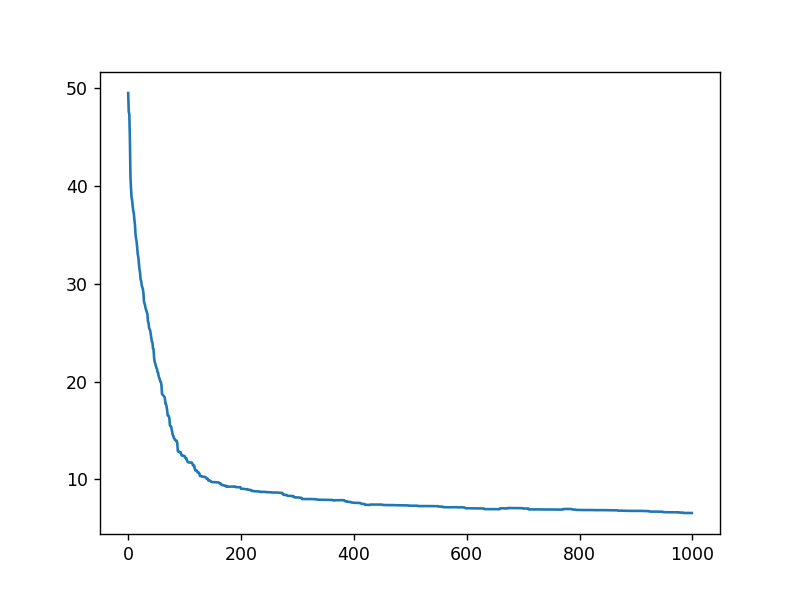

In [6]:
plt.figure()
plt.plot(Q2_saved)
plt.show()

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the $Q$-learning algorithm with a learning rate $\alpha=0.3$.

---

<IPython.core.display.Javascript object>


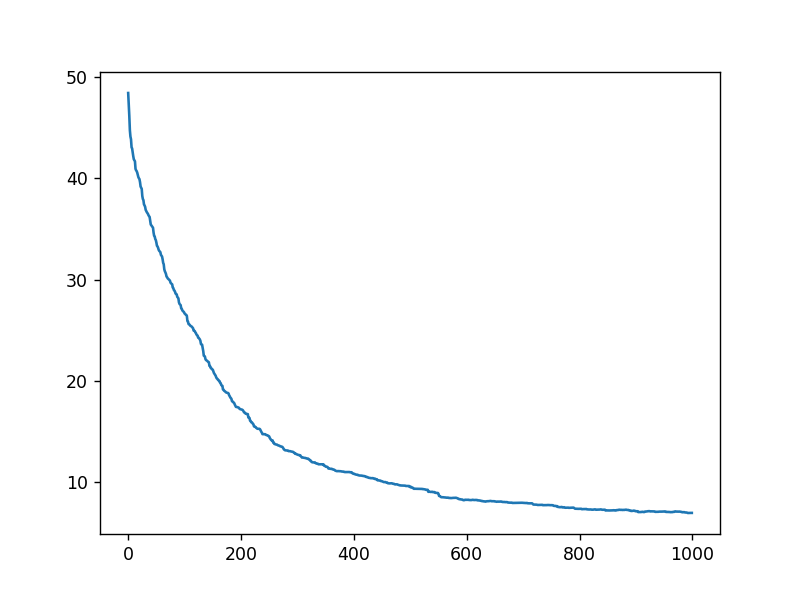

In [16]:
learning_rate = 0.3


x = rnd.choice(nX)
Q3 = np.zeros((nX,nA))
index = 0
Q3_saved = []
while index < 500000:
    xa = Q_greedy(x, Q3)
    next_x, done = act(x, xa)
    Q3[x, xa] = Q3[x, xa] + learning_rate*(c[x,xa] + gamma*min(Q3[next_x,:]) - Q3[x, xa])
    index +=1
    if ((index+1)%500)==0:
        Q3_saved.append(np.linalg.norm(Q1-Q3))
    x = next_x
    if done:
        done = False
        xa = Q_greedy(x, Q3)
        next_x, done = act(x, xa)
        Q3[x, xa] = Q3[x, xa] + learning_rate*(c[x,xa] + gamma*min(Q3[next_x,:]) - Q3[x, xa])
        index +=1
        if ((index+1)%500)==0:
            Q3_saved.append(np.linalg.norm(Q1-Q3))
        x = rnd.choice(nX)



plt.figure()
plt.plot(Q3_saved)
plt.show()

---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

<IPython.core.display.Javascript object>


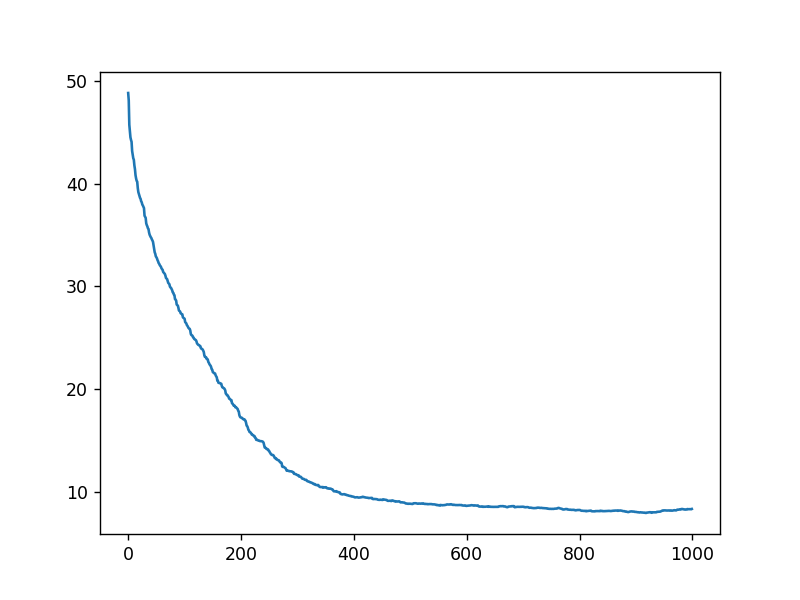

In [17]:

x = rnd.choice(nX)
Q4 = np.zeros((nX,nA))
xa = Q_greedy(x, Q4)
index = 0
Q4_saved = []
while index < 500000:
    next_x, done = act(x, xa)
    next_xa = Q_greedy(next_x, Q4)
    Q4[x, xa] = Q4[x, xa] + learning_rate*(c[x,xa] + gamma*Q4[next_x,next_xa] - Q4[x, xa])
    index +=1
    if ((index+1)%500)==0:
        Q4_saved.append(np.linalg.norm(Q1-Q4))
    x = next_x
    xa = next_xa
    if done:
        done = False
        next_x, done = act(x, xa)
        next_xa = Q_greedy(next_x, Q4)
        
        Q4[x, xa] = Q4[x, xa] + learning_rate*(c[x,xa] + gamma*Q4[next_x,next_xa] - Q4[x, xa])
        index +=1
        if ((index+1)%500)==0:
            Q4_saved.append(np.linalg.norm(Q1-Q4))
        x = rnd.choice(nX)
        xa = next_xa

            

plt.figure()
plt.plot(Q4_saved)
plt.show()

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

<IPython.core.display.Javascript object>


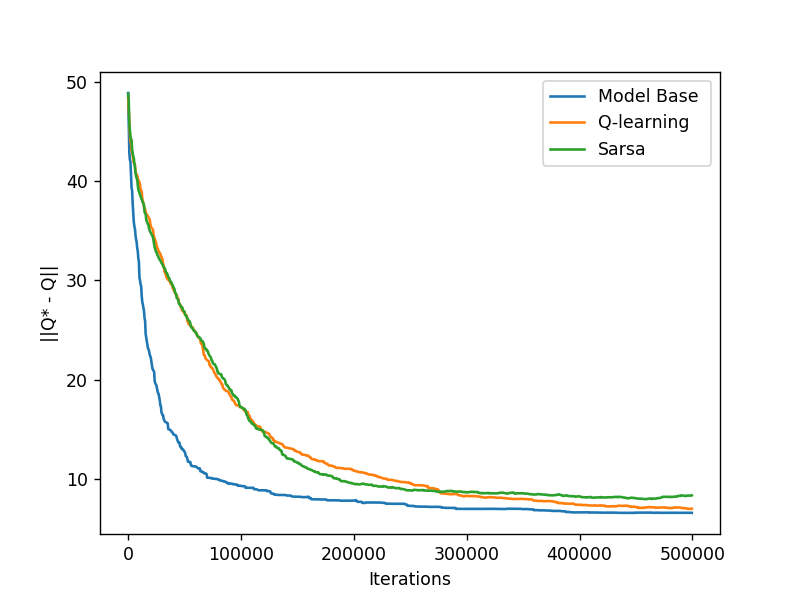

In [18]:
plt.figure()
xx = [i for i in range(1,500001,500)]
plt.plot(xx, Q2_saved, label='Model Base ')
plt.plot(xx, Q3_saved, label='Q-learning')
plt.plot(xx, Q4_saved, label='Sarsa')
plt.xlabel('Iterations')
plt.ylabel('||Q* - Q||')
plt.legend()
plt.show()

Answer: For the three algorithms (Model Based, Q-learning, SARSA), the results were expected, since the norm of the difference between the Q* and their Q values decreased over the iterations, as we can see from the plot above.
    The Model Based RL algorithm reaches better Q values earlier than the Value Based RL algorithms (Q-learning and SARSA), because, in the Model Based reinforcement learning the agent tries to capture 2 functions, the transition function from states and the reward function. From this model the agent can make predictions about what the next state and reward will be before it takes each action. And in the Value Based reinforcement learning the agent learns a policy directly using algorithms, in this case, Q-learning and SARSA.
    SARSA has the worst results, because it learns the value of the policy that it follows, in order to SARSA learn Q* must be combined with policy improvement, in this case, we should have used e-greedy, decaying e. 